# Imports

In [1]:
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch
from torch import nn
from IPython.testing import test
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pennylane as qml
import math
from torchvision import datasets, transforms

# Library imports
import random
import matplotlib.gridspec as gridspec
import pandas as pd


# Pytorch imports
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

ImportError: cannot import name 'test' from 'IPython.testing' (c:\Users\h4has\anaconda3\envs\qvisiongan\lib\site-packages\IPython\testing\__init__.py)

# Dataset

In [ ]:
batch_size = 1
image_size = 28

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self):
        super().__init__()
        transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])
        self.train_dataset = datasets.MNIST(
            root='./data',
            train=True,
            transform=transform,
            download=True
        )
        self.test_dataset = datasets.MNIST(
            root='./data',
            train=False,
            transform=transform,
            download=True
        )
         # Keep only samples with label 3
        self.train_dataset = [(img, label) for img, label in self.train_dataset if label == 3]
        self.test_dataset = [(img, label) for img, label in self.test_dataset if label == 3]


    def __len__(self):
        return len(self.train_dataset)

    def __getitem__(self, index):
        return self.train_dataset[index]

data_obj = MNISTDataset()
dataloader = DataLoader(data_obj.train_dataset, batch_size=batch_size, shuffle=True)

# Quantum Circuit

In [ ]:
# Quantum variables
n_qubits = 5  # Total number of qubits / N
n_a_qubits = 1  # Number of ancillary qubits / N_A
q_depth = 8  # Depth of the parameterised quantum circuit / D
n_generators = 56  # Number of subgenerators for the patch method / N_G

In [ ]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)
    # print("Wegiths After: ", weights)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CNOT(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    # print("probs  : ", probs)

    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    # print("probsgiven0  : ", probsgiven0)
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    # print("probsgiven  : ", probsgiven)
    return probsgiven

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):

        # print('x shape:', x.shape)

        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)
        subgen_ctr =0
        # Iterate over all sub-generators
        for params in self.q_params:
            subgen_ctr+=1
             # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor().to(device)

            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0)
                q_out = q_out[:,:14]
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self,input_size):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(input_size, 512),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(512, 256),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# Training Loop

In [ ]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.005  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [ ]:
discriminator = Discriminator(image_size * image_size).to(device)
generator = PatchQuantumGenerator(n_generators).to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(4, n_qubits, device=device) * math.pi / 2

# print('fized noise',fixed_noise)

# Iteration counter
counter = 0

# Collect images for plotting later
results = []
losses = []


while True:
    for i, (data, _) in enumerate(dataloader):
        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, n_qubits, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        # Append loss to list
        losses.append({'Iteration': counter, 'Discriminator Loss': errD.item(), 'Generator Loss': errG.item()})


        counter += 1
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        # # Show loss values
        if counter % 50 == 0:
            test_images = generator(fixed_noise).view(4,1,image_size,image_size).cpu().detach()
            results.append(test_images)
            # Define the path for saving model weights
            generator_path = f'generator_{n_qubits}qb_{counter}.pth'
            # Save the Generator model
            torch.save(generator.state_dict(), generator_path)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

# Convert the list to a DataFrame
losses_df = pd.DataFrame(losses)
# Save the DataFrame to a CSV file
losses_df.to_csv('training_losses_5qb_3.csv', index=False)

Iteration: 1, Discriminator Loss: 1.396, Generator Loss: 0.681
Iteration: 2, Discriminator Loss: 1.402, Generator Loss: 0.687
Iteration: 3, Discriminator Loss: 1.402, Generator Loss: 0.676
Iteration: 4, Discriminator Loss: 1.388, Generator Loss: 0.695
Iteration: 5, Discriminator Loss: 1.392, Generator Loss: 0.688
Iteration: 6, Discriminator Loss: 1.383, Generator Loss: 0.695
Iteration: 7, Discriminator Loss: 1.382, Generator Loss: 0.697
Iteration: 8, Discriminator Loss: 1.362, Generator Loss: 0.708
Iteration: 9, Discriminator Loss: 1.397, Generator Loss: 0.689
Iteration: 10, Discriminator Loss: 1.359, Generator Loss: 0.710
Iteration: 11, Discriminator Loss: 1.348, Generator Loss: 0.712
Iteration: 12, Discriminator Loss: 1.361, Generator Loss: 0.696
Iteration: 13, Discriminator Loss: 1.355, Generator Loss: 0.711
Iteration: 14, Discriminator Loss: 1.336, Generator Loss: 0.714
Iteration: 15, Discriminator Loss: 1.352, Generator Loss: 0.719
Iteration: 16, Discriminator Loss: 1.375, Generat

# Visualize generated images

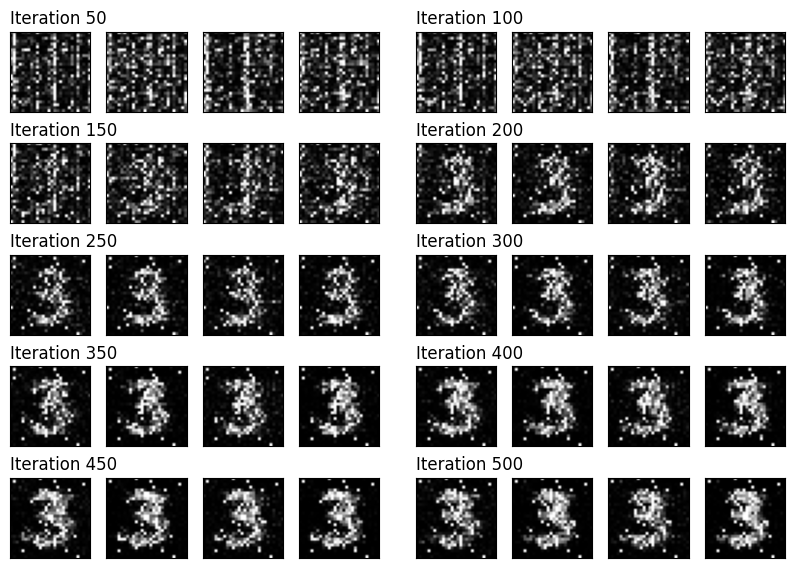

In [ ]:
fig = plt.figure(figsize=(10, 7))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()